In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [ ]:
# Load the image and convert it to grayscale.
# a = cv2.imread('resources/barcode/barcode114.png')
a = cv2.imread('resources/barcode/barcode111.png')
img = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
plt.imshow(img)

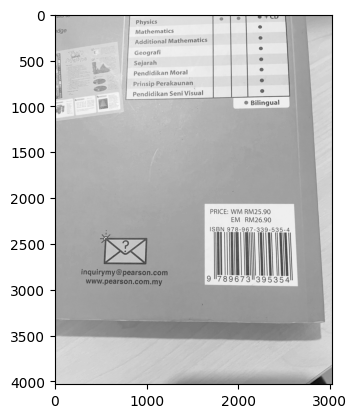

In [20]:
# Convert the image into grey for processing.
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')

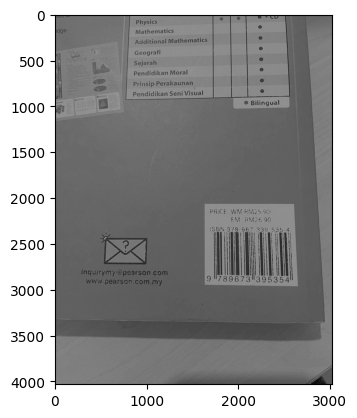

In [21]:
def highboost_filter(image, ksize):
    mean = np.ones(ksize, np.float32) / math.prod(ksize)
    blur = cv2.filter2D(image, -1, mean)
    edges = image - blur
    # Subtract the y-gradient from the x-gradient
    # edges = cv2.subtract(image, blur)
    # edges = cv2.convertScaleAbs(edges)

    return image + edges


boosted = highboost_filter(gray, (9, 9))
plt.imshow(boosted, cmap='gray')

In [ ]:
def detect_gradient(image):
    # Find vertical line intensity change (using x-axis, when y = 0).
    grad_x = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)

    # Find horizontal line intensity change(using y-axis, when x = 0).
    grad_y = cv2.Sobel(image, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=-1)

    # Subtract the y-gradient from the x-gradient
    grad = cv2.subtract(grad_x, grad_y)

    # Converts negative values to absolute values |x|.
    return cv2.convertScaleAbs(grad)


gradient = detect_gradient(boosted)

In [ ]:
plt.imshow(gradient, cmap='gray')

In [ ]:
# Blur and threshold the image.
def blur_threshold(image, ksize):
    blurred = cv2.blur(image, ksize=ksize)
    (_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
    return thresh


thresh = blur_threshold(gradient, [3, 3])

In [ ]:
plt.imshow(thresh, cmap='gray')

In [ ]:
# Construct closing SE and apply it to the thresholded image
def dilate(image, ksize, iteration):
    se = cv2.getStructuringElement(cv2.MORPH_RECT, ksize)
    closed = cv2.morphologyEx(image, cv2.MORPH_CLOSE, se)

    # perform a series of erosions and dilations
    # closed = cv2.erode(closed, None, iterations=iteration)
    closed = cv2.dilate(closed, None, iterations=iteration)
    return closed


morphed = dilate(thresh, [21, 7], 4)


In [ ]:
plt.imshow(morphed, cmap='gray')

In [ ]:
# find the contours in the thresholded image, then sort the contours by their area, keeping only the largest one
(cnts, _) = cv2.findContours(morphed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
c = sorted(cnts, key=cv2.contourArea, reverse=True)[0]
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
box = np.intp(cv2.boxPoints(rect))
# draw a bounding box arounded the detected barcode and display the image
cv2.drawContours(img, [box], -1, (0, 255, 0), 3)

In [ ]:
plt.imshow(img)

In [ ]:
# plt.imshow(box)
[X, Y, W, H] = cv2.boundingRect(box)
cropped = img[Y:Y + H, X:X + W]
plt.imshow(cropped)